## Including libraries and fetching data

In [13]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

bigData = loadmat('allParticipantsEEGData13.mat')

## Defining helper functions
These help to view the data and get the data on the right format

In [32]:
def print_formatted_struct(data, indent_level=0):
    """
    Recursively print the fields of a MATLAB struct loaded into Python.
    Prints the size of arrays instead of their content.
    """
    indent = '-' * indent_level

    # Check if the data is a structured numpy array
    if isinstance(data, np.ndarray):
        # Check if it's a structured array (with named fields)
        if data.dtype.names is not None:
            for name in data.dtype.names:
                print(f"{indent}{name}:")
                # Recursively print each field
                field_data = data[name][0, 0]  # Adjust indexing based on your data's structure
                print_formatted_struct(field_data, indent_level + 1)
        else:
            # Print the size of the array
            print(f"{indent}[Array of shape {data.shape}]")
    elif isinstance(data, dict):
        for key, value in data.items():
            print(f"{indent}{key}:")
            print_formatted_struct(value, indent_level + 1)
    else:
        # Print summary for other data types
        print(f"{indent}{str(data)}")

def get_data(data, subject, run, electrode):
    # Get the data
    subject = 'P{:03d}'.format(subject + 1)
    run = 'R{:03d}'.format(run + 1)
    signal = data[subject][0,0]['train'][0,0][run][0,0]['X'][0,0][:,electrode]
    labels = data[subject][0,0]['train'][0,0][run][0,0]['y'][0,0][0]
    trial = data[subject][0,0]['train'][0,0][run][0,0]['trial'][0][0][0]
    fs = data[subject][0,0]['train'][0,0][run][0,0]['fs'][0,0][0][0]
    classes = [data[subject][0,0]['train'][0,0][run][0,0]['classes'][0,0][0][i][0] for i in range(len(data[subject][0,0]['train'][0,0][run][0,0]['classes'][0,0][0]))]
    return signal, labels, trial, fs, classes

def splitt_by_class(data, subject, run, electrode, max_len = -1, seconds_of_pre_trial_data=3):
    """
    Split the data in two classes: right hand and feet.
    y=1 -> right hand
    y=2 -> feet

    seconds_of_pre_trial_data: number of seconds of data to include before the trial starts, this is a sort of baseline.
    """
    signal, labels, trial, fs, _ = get_data(data, subject, run, electrode)

    if seconds_of_pre_trial_data*fs > trial[0]:
        print('seconds_of_pre_trial_data is too big, it must be smaller than the first trial.')
        return None

    # Split the data
    right_hand_seqences = []
    feet_seqences = []

    max_length = max([trial[j+1]-trial[j] for j in range(len(trial)-1)]) if max_len == -1 else max_len

    for i in range(len(trial)):
        current_trial = trial[i]
        next_trial = -1 if i == len(trial)-1 else trial[i+1]
        length = next_trial - current_trial if next_trial != -1 else max_length

        signal_trial_piece = signal[current_trial-fs*seconds_of_pre_trial_data:current_trial+length]
        if length < max_length: ## Zero pad the signal
            signal_trial_piece = np.append(signal_trial_piece, np.zeros(max_length - length))

        if labels[i] == 1:
            right_hand_seqences.append(signal_trial_piece)
        elif labels[i] == 2:
            feet_seqences.append(signal_trial_piece)
    if len(right_hand_seqences)+len(feet_seqences) != len(trial):
        print('Error: number of trials does not match the number of sequences.')
    return right_hand_seqences, feet_seqences

def get_avg_in_freq(data, SamplingFrequency, LengthOfEpochs):
    """
    Avarages in frequency domain and returns result in both time and frequency domain.
    Takes in a list of lists of signal epochs.
    """
    # Convert each list to frequency domain and avarge them
    fft_data = [np.fft.fft(signal) for signal in data]
    avg_fft = np.mean(fft_data, axis=0)
    avg_time_domain = np.fft.ifft(avg_fft)

    return avg_fft, avg_time_domain, np.fft.fftfreq(LengthOfEpochs, 1/SamplingFrequency)

def get_subject_dict_avg(data, subject, seconds_of_pre_trial_data=3):
    """
    Avarage the data in a given run. Data must be for one participant.
    """
    subject_formated = 'P{:03d}'.format(subject + 1)
    fs = data[subject_formated][0,0]['train'][0,0]['R001'][0,0]['fs'][0,0][0][0]
    num_electrodes = data[subject_formated][0,0]['train'][0,0]['R001'][0,0]['X'][0,0].shape[1]
    subject_dict = {}
    for electrode in range(num_electrodes):  # For each electrode
        #pick the longest trial
        right_hand_seqences = []
        feet_seqences = []
        subj_train = data[subject_formated][0,0]['train'][0,0][0,0]

        max_length = 0
        num_runs = len(subj_train)  # Assuming this is the number of runs

        for run in range(num_runs):
            run_label = 'R{:03d}'.format(run + 1)
            num_trials = len(subj_train[run_label][0,0]['trial'][0])

            for j in range(num_trials-1):
                trial_length = subj_train[run_label][0,0]['trial'][0][j+1] - subj_train[run_label][0,0]['trial'][0][j]
                max_length = max(max_length, trial_length)

        for run in range(num_runs): # For each run
            # split in epochs depending on hands or feet
            right_hand_seqences_new, feet_seqences_new = splitt_by_class(data, subject, run, electrode, max_length, seconds_of_pre_trial_data)
            right_hand_seqences_new_fixed = [np.append(signal, np.zeros(max_length+fs*seconds_of_pre_trial_data - len(signal))) for signal in right_hand_seqences_new]
            feet_seqences_new_fixed = [np.append(signal, np.zeros(max_length+fs*seconds_of_pre_trial_data - len(signal))) for signal in feet_seqences_new]
            
            right_hand_seqences.extend(right_hand_seqences_new_fixed)
            feet_seqences.extend(feet_seqences_new_fixed)
        # Avarage the data in frequency domain
        rh_freq_avg, rh_time_avg, freq_axis = get_avg_in_freq(right_hand_seqences, fs, max_length+fs*seconds_of_pre_trial_data)
        feet_freq_avg, feet_time_avg, _ = get_avg_in_freq(feet_seqences, fs, max_length+fs*seconds_of_pre_trial_data)

        subject_dict[electrode] = {
            'right_hand_avg_time': np.mean(right_hand_seqences, axis=0), 
            'feet_avg_time': np.mean(feet_seqences, axis=0),
            'right_hand_avg_freq': rh_freq_avg,
            'feet_avg_freq': feet_freq_avg,
            'right_hand_time_from_freq': rh_time_avg,
            'feet_time_from_freq': feet_time_avg,
            'freq_axis': freq_axis
            }
        
    return subject_dict



def plot_subject_avg(subject_dict):
    num_electrodes = len(subject_dict)

    # Iterate over each electrode
    for electrode in range(num_electrodes):  
        data = subject_dict[electrode]

        # Create a figure with subplots
        fig, axs = plt.subplots(3, 2, figsize=(15, 9))
        fig.suptitle(f'Electrode {electrode + 1}/{num_electrodes}')

        # Plotting time domain averages
        axs[0, 0].plot(data['right_hand_avg_time'])
        axs[0, 0].set_title('Right Hand - Avg Time Domain')
        axs[0, 1].plot(data['feet_avg_time'])
        axs[0, 1].set_title('Feet - Avg Time Domain')

        # Plotting frequency domain averages
        axs[1, 0].plot(data['freq_axis'], np.abs(data['right_hand_avg_freq']))  # Plot magnitude of FFT
        axs[1, 0].set_xlim(0, 45)  # Limit x-axis from 0 to 45 Hz
        axs[1, 0].set_title('Right Hand - Avg Frequency Domain')
        axs[1, 0].set_xlabel('Frequency (Hz)')
        axs[1, 1].plot(data['freq_axis'], np.abs(data['feet_avg_freq']))  # Plot magnitude of FFT
        axs[1, 1].set_xlim(0, 45)  # Limit x-axis from 0 to 45 Hz
        axs[1, 1].set_title('Feet - Avg Frequency Domain')
        axs[1, 1].set_xlabel('Frequency (Hz)')

        # Plotting inverse FFT signals
        axs[2, 0].plot(data['right_hand_time_from_freq'])
        axs[2, 0].set_title('Right Hand - Time From Freq')
        axs[2, 1].plot(data['feet_time_from_freq'])
        axs[2, 1].set_title('Feet - Time From Freq')

        # Adjust layout and show plot
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
def plot_compare_electrodes(subject_dict, TimeOrFreq):
    if TimeOrFreq.lower() != 'time' and TimeOrFreq.lower() != 'freq' and TimeOrFreq.lower() != 'frequency':
        raise ValueError("TimeOrFreq must be either 'time' or 'freq'")
    num_electrodes = len(subject_dict)
    if TimeOrFreq.lower() == 'freq' or TimeOrFreq.lower() == 'frequency':
        hand = "right_hand_avg_freq"
        feet = "feet_avg_freq"
    elif TimeOrFreq.lower() == 'time':
        hand = "right_hand_time_from_freq"
        feet = "feet_time_from_freq"
    
    # Create a figure with subplots
    fig_hand, axs_hand = plt.subplots(5, 3, figsize=(30, 18))
    fig_feet, axs_feet = plt.subplots(5, 3, figsize=(30, 18))
    if "freq" in TimeOrFreq.lower():
        fig_hand.suptitle(f'Right Hand Frequency Plots for all electrodes') 
        fig_feet.suptitle(f'Feet Frequency Plots for all electrodes')
        for electrode in range(num_electrodes):  
            data = subject_dict[electrode]
            axs_hand[electrode%5, electrode//5].set_title(f'Electrode {electrode + 1}/{num_electrodes}')
            axs_feet[electrode%5, electrode//5].set_title(f'Electrode {electrode + 1}/{num_electrodes}')
            axs_hand[electrode%5, electrode//5].plot(data['freq_axis'], np.abs(data[hand]))
            axs_hand[electrode%5, electrode//5].set_xlim(0, 20)  # Limit x-axis from 0 to 45 Hz
            axs_feet[electrode%5, electrode//5].plot(data['freq_axis'], np.abs(data[feet]))
            axs_feet[electrode%5, electrode//5].set_xlim(0, 20)  # Limit x-axis from 0 to 45 Hz
    else:
        fig_hand.suptitle(f'Right Hand Time Plots for all electrodes') 
        fig_feet.suptitle(f'Feet Time Plots for all electrodes')
        for electrode in range(num_electrodes):  
            data = subject_dict[electrode]
            axs_hand[electrode%5, electrode//5].set_title(f'Electrode {electrode + 1}/{num_electrodes}')
            axs_feet[electrode%5, electrode//5].set_title(f'Electrode {electrode + 1}/{num_electrodes}')
            axs_hand[electrode%5, electrode//5].plot(data[hand])
            axs_feet[electrode%5, electrode//5].plot( data[feet])

## Put data on the right format
The format is a dictonary per subject with each electorde as key. Inside each electode are six different signals as well as the frequency axis used for plotting. The signals are the time avarge for each epoch for the two classes, the frequency signals avarage for each epoch for the two classes, and these requency avarages moved back to time domain.

In [15]:
bigData.keys()
data = bigData['bigData']

subject0 = get_subject_dict_avg(data,0)


## Plot data

/Users/erlenwit/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


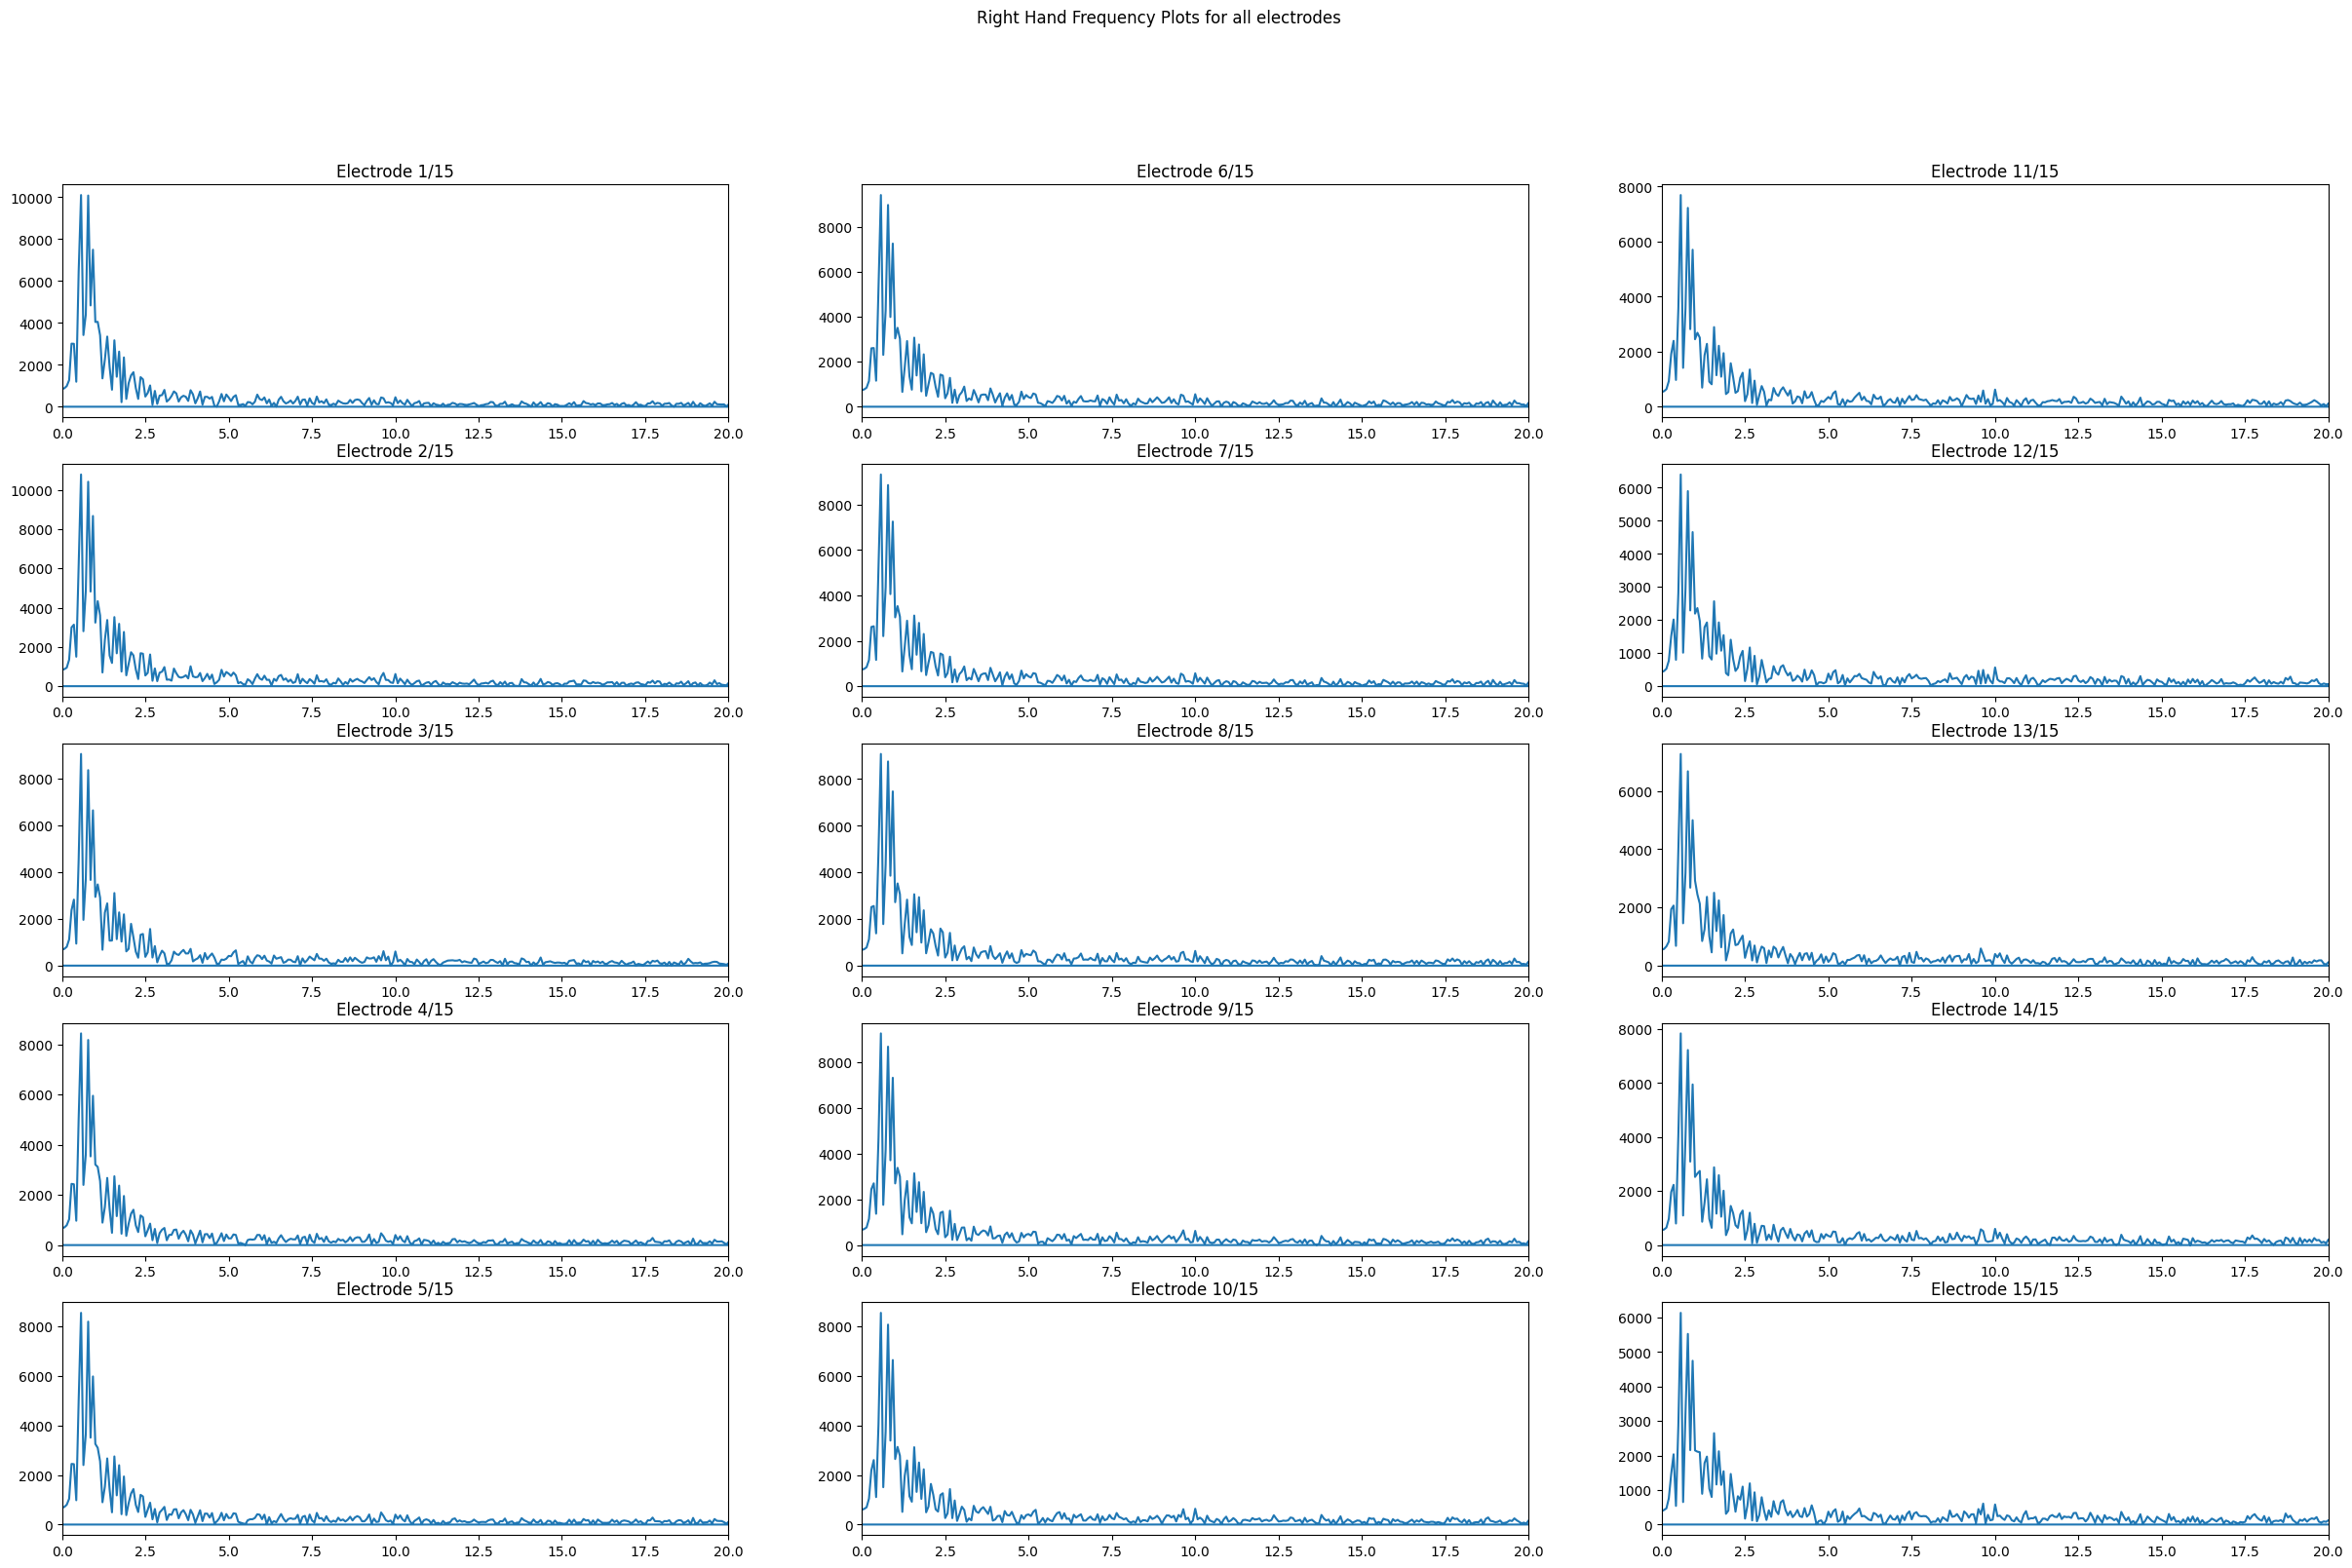

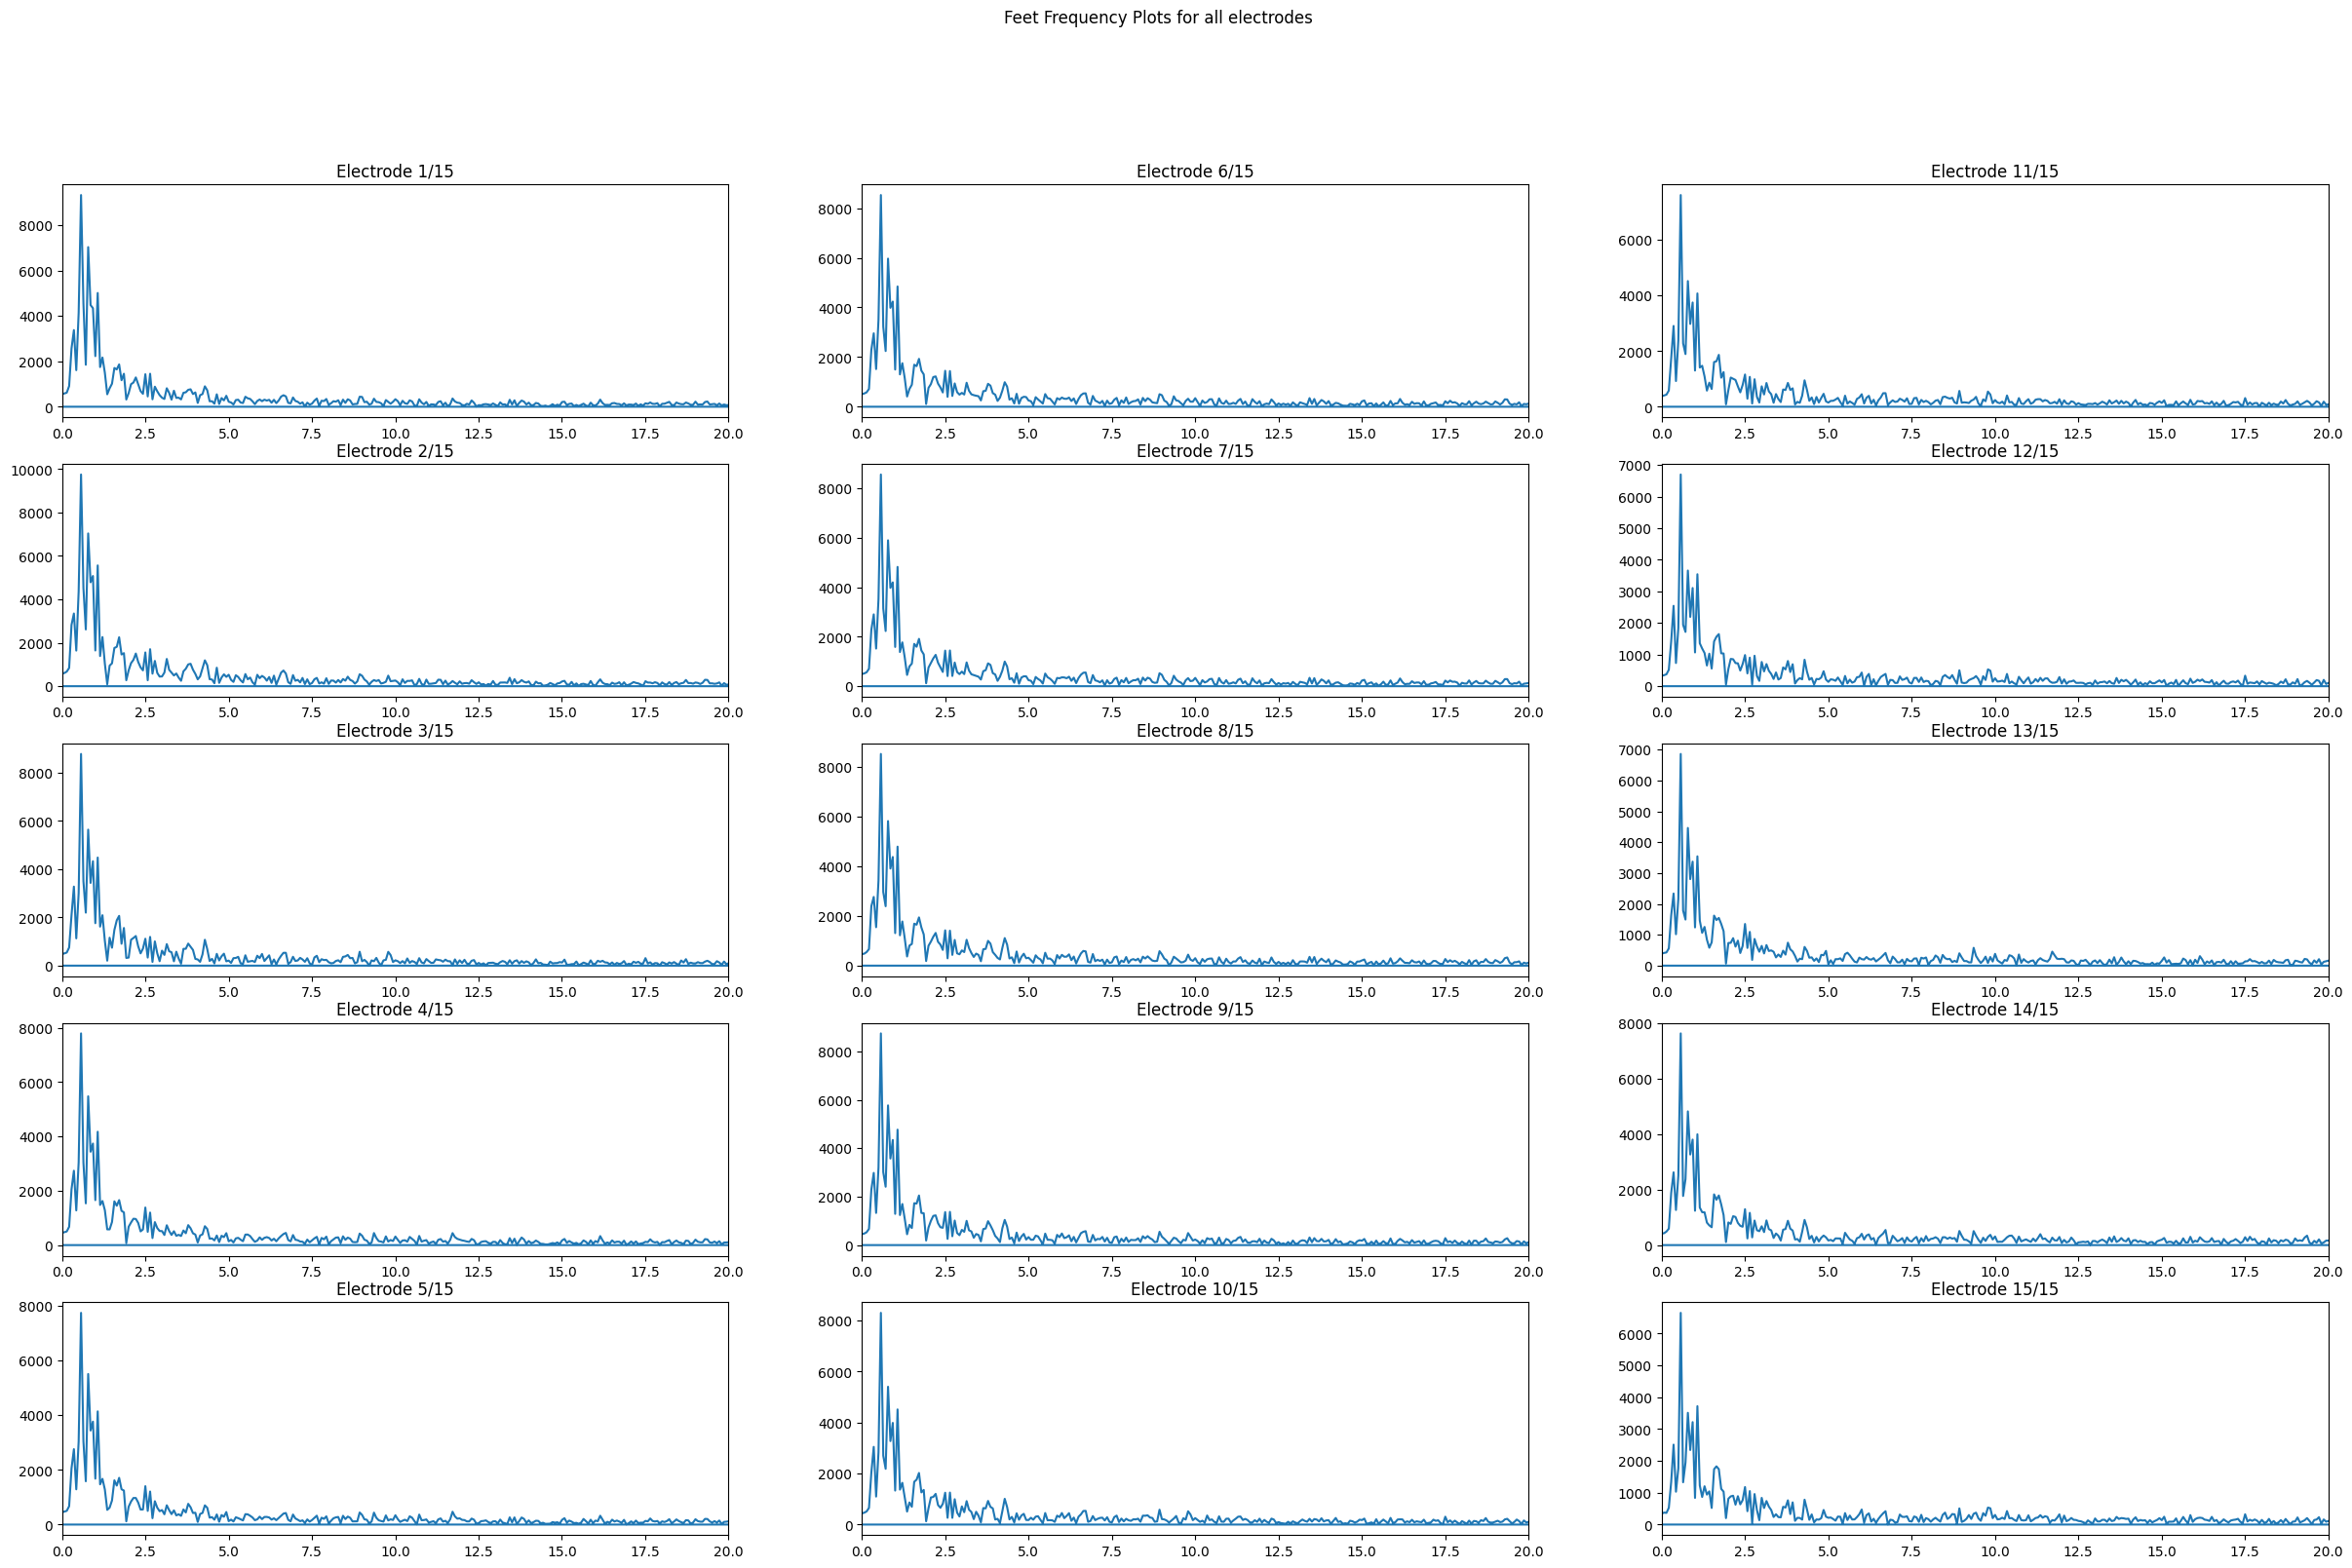

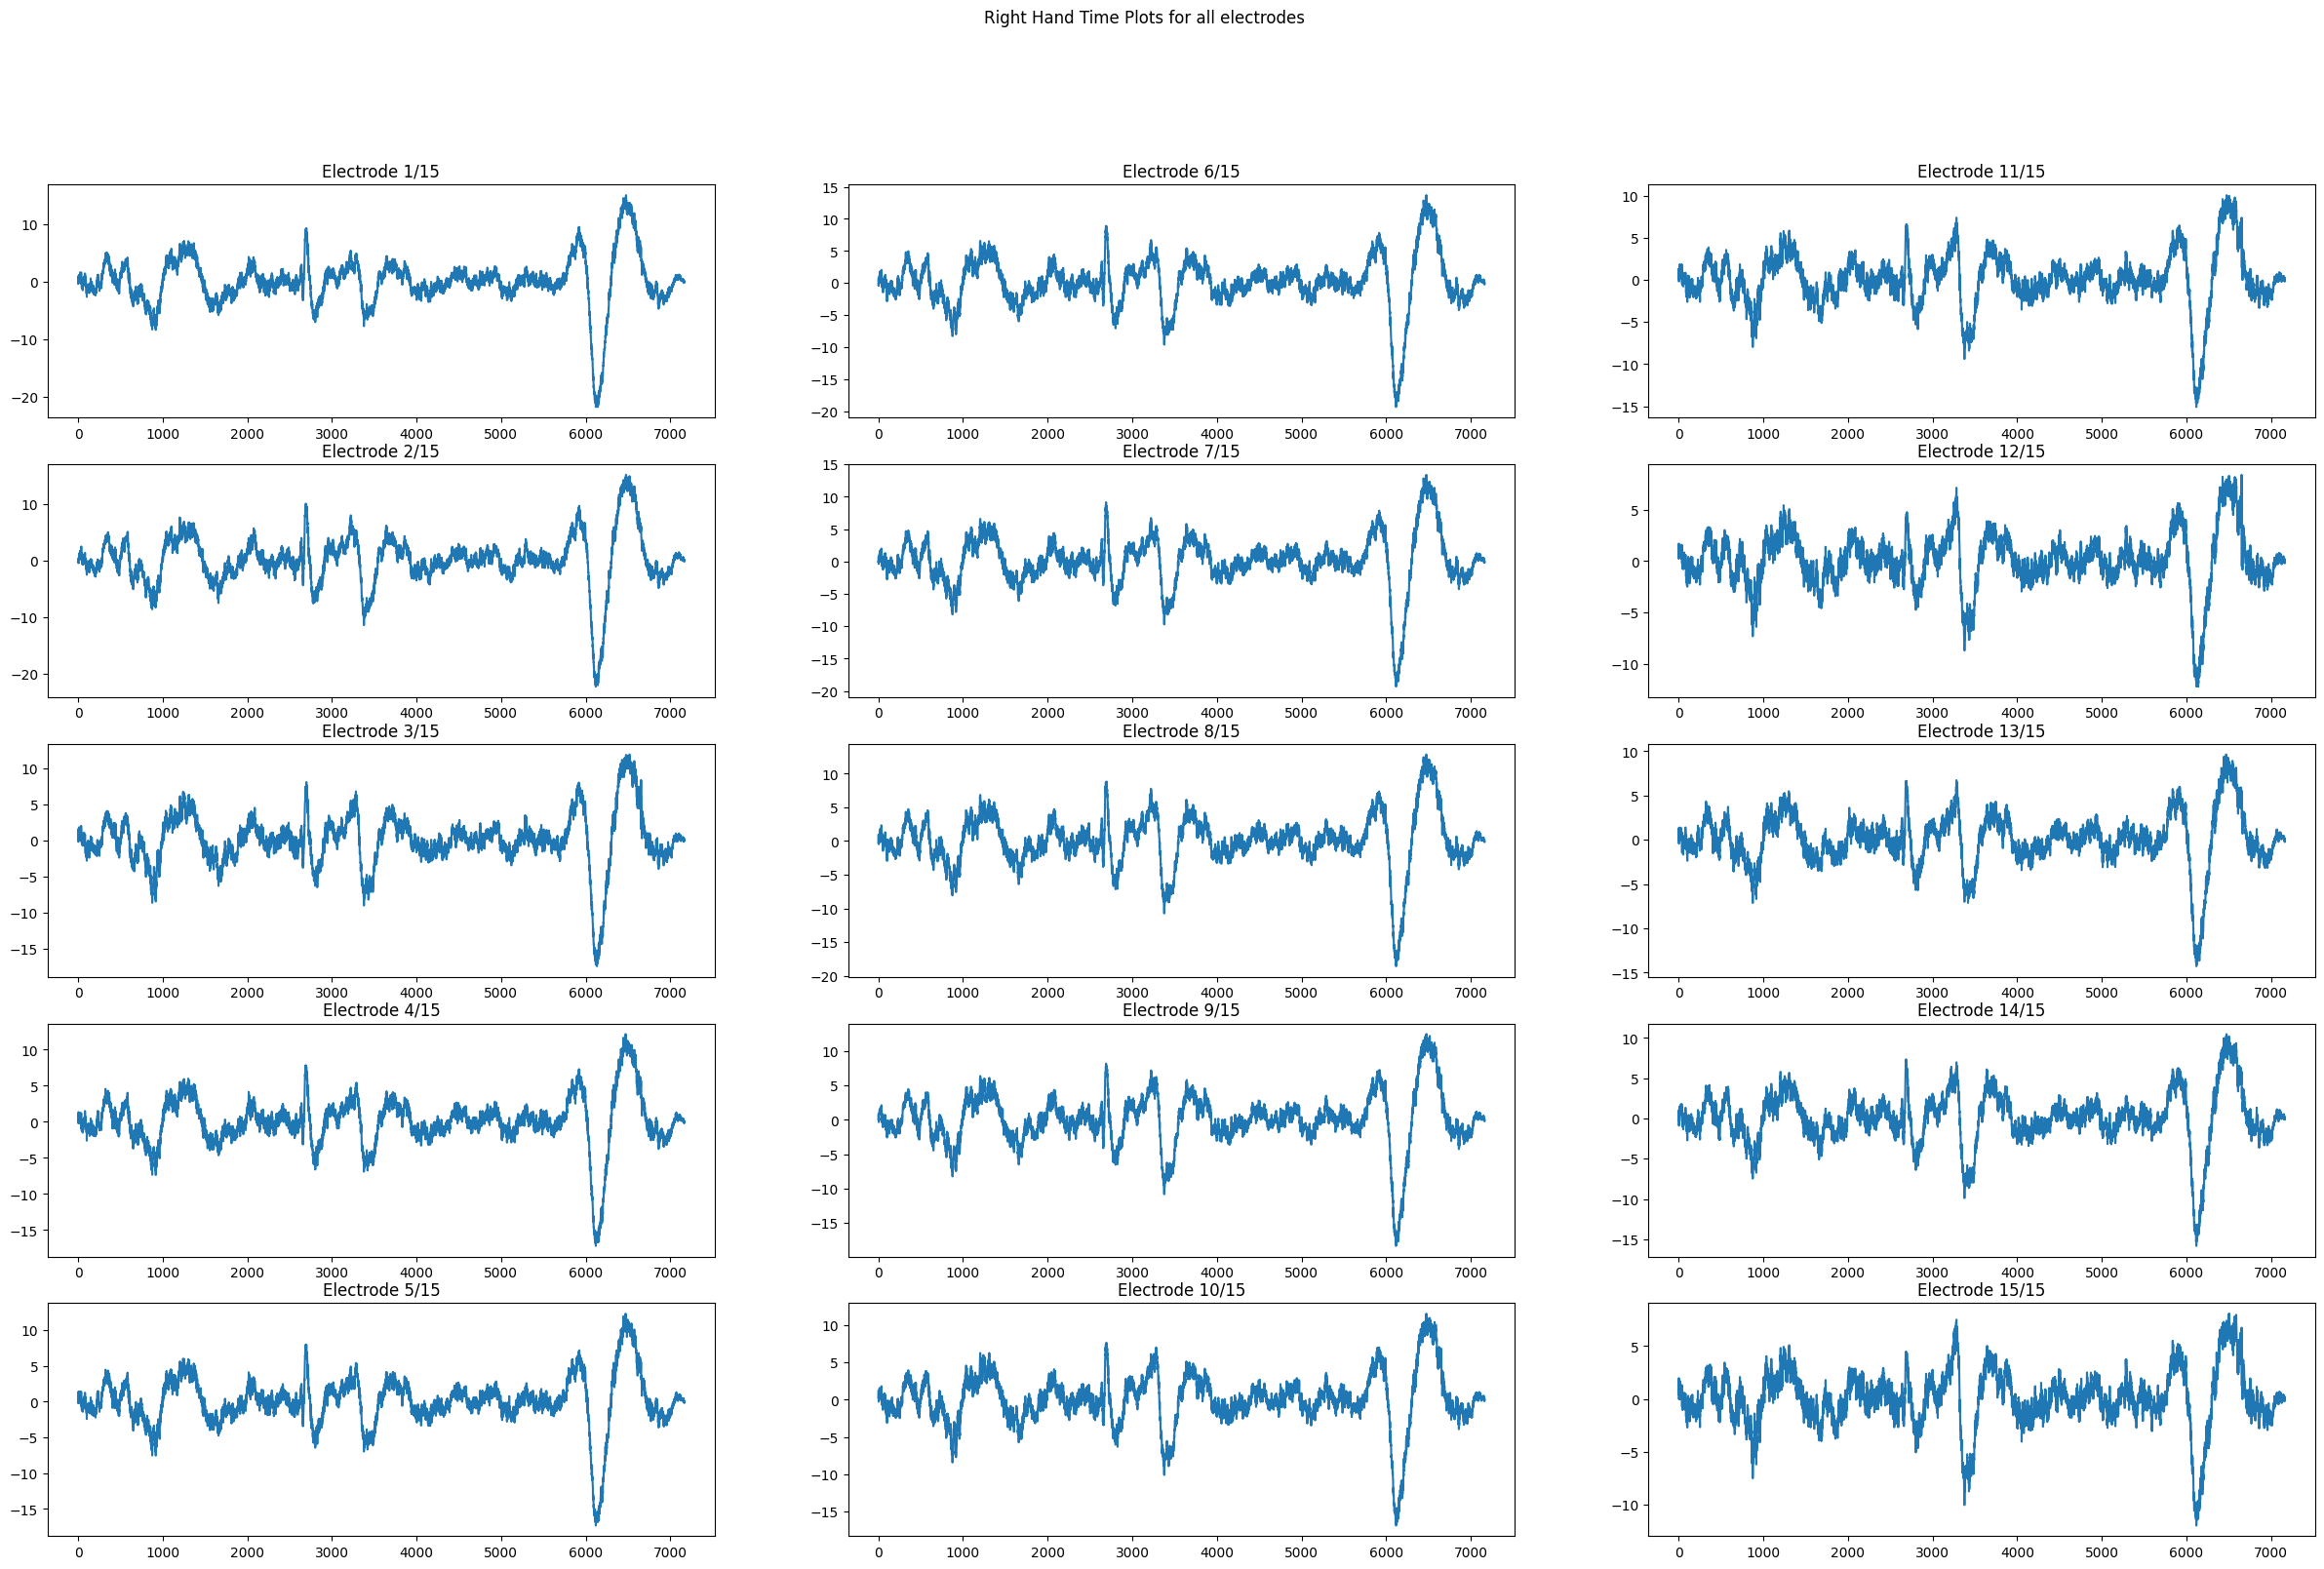

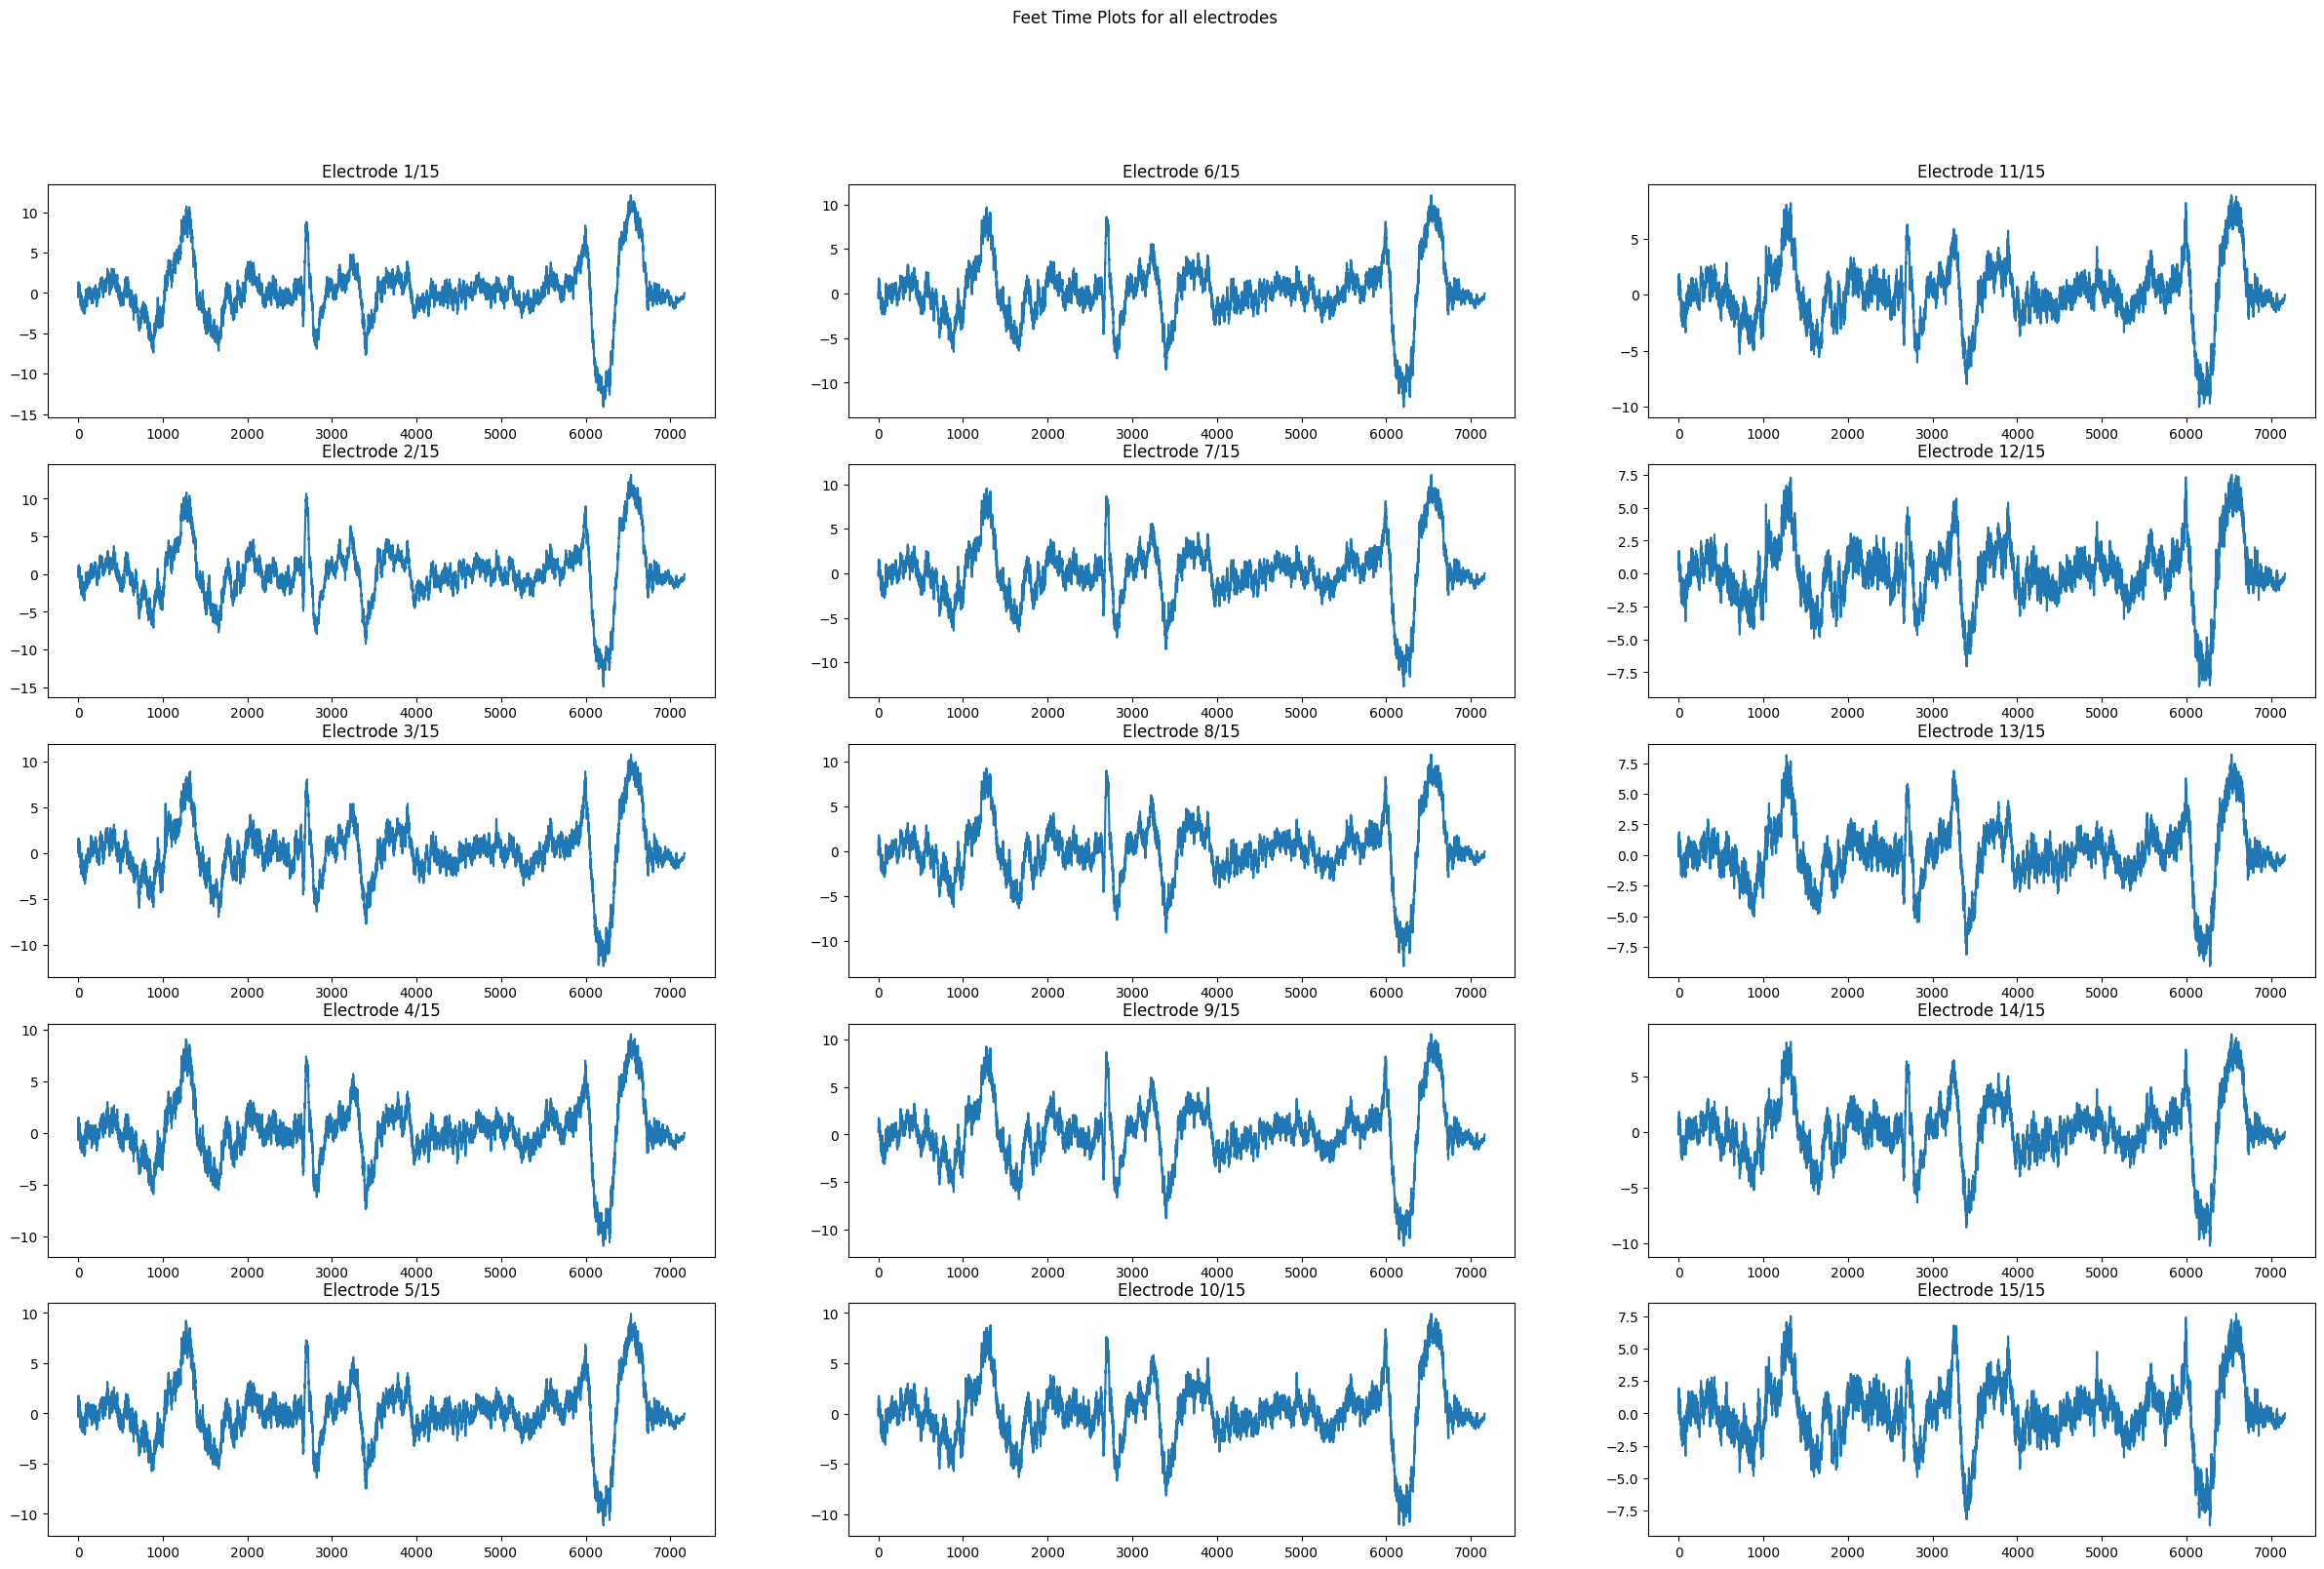

In [33]:
#print_formatted_struct(data)
#print_formatted_struct(subject0)
#plot_subject_avg(subject0)
plot_compare_electrodes(subject0, 'freq')
plot_compare_electrodes(subject0, 'time')